In [1]:
import sqlalchemy as sqla
import sys
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# Connect to DB

In [71]:
# Chose the DB
db_input_2021 = input ("What database should we use?\n\n")

# Create the sqlalchemy engine
db_engine_2021 = sqla.create_engine(db_input_2021) #is taken by pd.read_sql_query function later on

# Test connection
try:
    db_connection = db_engine_2021.connect()
except Exception as exc:
    print("\nCouldn't connect to the database\n")
    try:
        print(exc.message, exc.args)
    except:
        pass
    sys.exit()
        
# If everything goes well, just be happy about it!
    print("\nHooray! We connected to the database!")

In [72]:
# Chose the DB
db_input_2020 = input ("What database should we use?\n\n")

# Create the sqlalchemy engine
db_engine_2020 = sqla.create_engine(db_input_2020) 

# Test connection
try:
    db_connection = db_engine_2020.connect()
except Exception as exc:
    print("\nCouldn't connect to the database\n")
    try:
        print(exc.message, exc.args)
    except:
        pass
    sys.exit()
        
# If everything goes well, just be happy about it!
    print("\nHooray! We connected to the database!")

# - Input data -

## Scraping for EGID, GBAUP, GBAUJ, GKLAS, GKAT

In [ ]:
# List of EGIDs from merged_egid_intersect: we have SATOM measurements for it

egid_df = pd.read_sql_query("SELECT DISTINCT EGID FROM city.merged_egid_intersect", db_engine_2021).dropna()
niter = egid_df.shape[0]

#Initiating storage for the scrapping results: empty Dataframe with default values
data = {"EGID": np.repeat(0,niter), "GBAUP": np.repeat(0,niter), "GBAUJ": np.repeat(0,niter),"GKLAS": np.repeat(0,niter), "GKAT": np.repeat(0,niter), "E": np.repeat(0,niter), "N": np.repeat(0,niter), "gastw": np.repeat(0,niter)}
data_df = pd.DataFrame(data)

In [ ]:
GEOADMIN_BASE_URL = "https://api.geo.admin.ch/rest/services/ech/MapServer/ch.bfs.gebaeude_wohnungs_register/"

# Scraping to get EGID, GBAUP, GBAUJ, GKALS, GKAT, gastw (number floors)

for i in range(niter): 

    EGID = egid_df.iloc[i];
    print("Setting building", EGID) 
 
    url = GEOADMIN_BASE_URL + str(int(EGID.values[0])) + "_0"
    response = requests.get(url=url)
    print(response)

    # scrapping blocked by map.geo.admin.ch
    if response.status_code != 200:
        print("Scrapping blocked by map.geo.admin.ch")
    
    else:
        regbl = response.json()
        
        
    
    # Collecting data during scraping 
    data_df.iloc[i,0] = int(EGID)
    
    if regbl["feature"]["attributes"]["gbaup"] is None:
        data_df.iloc[i,1] = np.nan
    else:
        data_df.iloc[i,1] = int(regbl["feature"]["attributes"]["gbaup"])
    
    if regbl["feature"]["attributes"]["gbauj"] is None:
        data_df.iloc[i,2] = np.nan
    else:
        data_df.iloc[i,2] = int(regbl["feature"]["attributes"]["gbauj"])
        
    if regbl["feature"]["attributes"]["gklas"] is None:
        data_df.iloc[i,3] = np.nan
    else:
        data_df.iloc[i,3] = int(regbl["feature"]["attributes"]["gklas"])
    
    if regbl["feature"]["attributes"]["gkat"] is None:
        data_df.iloc[i,4] = np.nan
    else:
        data_df.iloc[i,4] = int(regbl["feature"]["attributes"]["gkat"])
        
    if regbl["feature"]["attributes"]["gastw"] is None:
        data_df.iloc[i,7] = np.nan
    else:
        data_df.iloc[i,7] = int(regbl["feature"]["attributes"]["gastw"])
    

    data_df.iloc[i,5] = float(regbl["feature"]["geometry"]["x"])
    data_df.iloc[i,6] = float(regbl["feature"]["geometry"]["y"])

### Using locally saved data

In [73]:
"""Saving for future use. Uncomment to save table to computer"""
#data_df.to_csv('data_df')

""" Instead of scraping each time, can open csv form computer again"""
#data_path = 'data_df' #Make sure the data_df has been saved to the current working directory
#data_df = pd.read_csv(data_path, index_col=0)

## Geometry

In [74]:
envelope = gpd.read_postgis(
        "SELECT surf.geometry AS geometry, thema.objectclass_id AS class_id, REGBL.egid AS egid, surf.cityobject_id AS cityobject_id, construction.constr_id as composite_id " #keep space before quote
        "FROM city.regbl_data REGBL "
        #"FROM citydb.cross_reference cros "
        "LEFT JOIN citydb.cross_reference cros ON cros.egid = REGBL.egid " #remove if doing whole area building_root_id [egid] satom (root_id)
        "JOIN citydb.building build ON build.building_root_id = cros.building_root_id " # [building_root_id] egid satom root_id (building_id objectclass_id building_parent_id)
        #"JOIN citydb.building build ON build.building_root_id = cros.building_root_id AND cros.egid = 190056978 "
        "LEFT JOIN citydb.thematic_surface thema ON thema.building_id = build.id " # building_root_id egid satom root_id [building_id] objectclass_id building_parent_id (thematic_surface_id objeclass_id building_id lod2_multisurface_id)
        "LEFT JOIN citydb.building_installation install ON install.building_id = build.id " # building_root_id egid satom root_id [building_id] objectclass_id building_parent_id thematic_surface_id objeclass_id building_id lod2_multisurface_id (thema.objectclass_id lod2_brep_id)
        "JOIN citydb.surface_geometry surf ON (surf.root_id = thema.lod2_multi_surface_id OR surf.root_id = install.lod2_brep_id) AND surf.geometry IS NOT NULL " # OR surf.root_id = install.lod2_brep_id OR zone.root_id = surf.root_id #remove OR shade.root_id = surf.root_id if doing without shading surfaces
        # building_root_id egid satom root_id building_id objectclass_id building_parent_id thematic_surface_id objeclass_id building_id [lod2_multisurface_id] thema.objectclass_id [lod2_brep_id] (geometry parent_id)
        #"LEFT JOIN city.regbl_data rbl ON rbl.egid = cros.egid "  # building_root_id [egid] satom root_id building_id objectclass_id building_parent_id thematic_surface_id objeclass_id building_id lod2_multisurface_id thema.objectclass_id lod2_brep_id geometry parent_id (construction_period)
        "LEFT JOIN citydb.nrg8_cityobj_to_constr construction ON surf.cityobject_id = construction.cityobject_id",
        #"LEFT JOIN surfaces_data.default_composites comp ON comp.class_id = thema.objectclass_id AND rbl.construction_year BETWEEN comp.period_start AND comp.period_end",
        db_engine_2021, geom_col='geometry')

envelope = envelope.dropna(subset=['composite_id'])
envelope = envelope.dropna(subset=['geometry'])
envelope = envelope.drop_duplicates(subset=['geometry'])
envelope = envelope.drop(["composite_id"], axis=1)

#Keep floors objid =35
envelope = envelope[envelope["class_id"]==35]

envelope["geometry"] = envelope["geometry"].area

floor_areas = envelope.groupby(['egid']).sum()
floor_areas_final = floor_areas.drop(["class_id", "cityobject_id"], axis=1)

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [75]:
# Calculating building volume

vol_df = pd.merge(floor_areas, data_df, left_on="egid", right_on="EGID",how="left")
vol_df = vol_df.dropna(subset=["EGID", "GBAUP", "GKLAS", "GKAT", "gastw"])
vol_df["volume"] = np.multiply(vol_df["geometry"],vol_df["gastw"]*4) # Assume that each floor is 4m
input_df = vol_df
input_df

,geometry,class_id,cityobject_id,EGID,GBAUP,GBAUJ,GKLAS,GKAT,E,N,gastw,volume
0,110.230510,175.0,193390,923868.0,8012.0,NaN,1110.0,1020.0,560789.8,127748.5,2.0,881.844080
2,109.844431,70.0,73758,923909.0,8015.0,NaN,1110.0,1020.0,561157.8,127489.8,3.0,1318.133166
3,18.353558,105.0,87018,923912.0,8013.0,NaN,1110.0,1030.0,561256.0,127250.7,1.0,73.414232
9,256.916107,2730.0,2304354,923962.0,8015.0,NaN,1122.0,1020.0,560732.4,125678.1,3.0,3082.993290
11,96.441709,140.0,140748,923971.0,8011.0,NaN,1122.0,1030.0,560529.9,125410.6,3.0,1157.300508
...,...,...,...,...,...,...,...,...,...,...,...,...
543,123.992696,210.0,336564,191579561.0,8023.0,2017.0,1122.0,1020.0,562641.4,122215.3,6.0,2975.824692
545,40.287417,105.0,205455,191621572.0,8016.0,1985.0,1110.0,1030.0,562070.3,122726.3,2.0,322.299332
551,32.174796,350.0,549982,191649872.0,8012.0,1919.0,1110.0,1020.0,562088.4,122254.3,3.0,386.097558
553,19.171948,175.0,330875,191696052.0,8023.0,2019.0,1122.0,1020.0,562044.4,122260.3,5.0,383.438960


## Meteo data

In [76]:
meteo_path = 'Aigle_MeteoSchweiz_2019_v2.cli'
# Take the climate file and remove the header
# keep only columns woth data
meteo_df = pd.read_csv(meteo_path, delimiter=' ')
meteo_df = meteo_df.drop(["FF", "DD", "RH", "N"], axis=1)

In [77]:
meteo_df

,dm,m,h,G_Dh,G_h,Ta,Ts,RR
0,1,1,1,0.2,2.00,0.84,4.40,0.0
1,1,1,2,0.0,2.00,0.72,4.33,0.0
2,1,1,3,0.0,2.00,0.45,4.30,0.0
3,1,1,4,0.0,1.83,0.13,4.30,0.0
4,1,1,5,0.0,2.00,0.45,4.23,0.0
...,...,...,...,...,...,...,...,...
8755,31,12,20,0.0,2.00,0.83,4.30,0.0
8756,31,12,21,0.0,2.00,0.70,4.30,0.0
8757,31,12,22,0.0,2.00,0.12,4.30,0.0
8758,31,12,23,0.0,2.00,0.27,4.30,0.0


#  - Output data -

## 2019 cumulative demand measured by SATOM --> keep timestamps and energies of 2019 only

In [ ]:
"""
#################
In practice, need to create the whole nrg8_time_series to get the table like it is in the DB.
There is a problem how every when trying to do: nrg8_time_series["time_array"].apply(pd.Series)
Python cannot convert NaT to series
Possible code: 
    #from pandas.tseries.converter import register
    #register()
Since this doesn't work, here we don't make the nrg8_time_series table and simply collect data from satom database
#################

# CODE TO COLLECT DATA FROM CITYDB/ENERGYADE SCHEMA

# SATOM timeseries saved in nrg8_time_series
time_series = pd.read_sql_query("SELECT gmlid, time_array, values_array FROM citydb.nrg8_time_series WHERE interpolation_type='AverageInSucceedingInterval' AND acquisition_method='Measurement' ", db_engine_2021)

time_df = time_series["time_array"].apply(pd.Series)

#Set the row indexes as gmlid
new_idx = time_series["gmlid"]
time_df = time_df.rename(index=new_idx)

time_df = pd.DataFrame(time_df.stack())

time_df.reset_index(inplace=True) 

# Split timestamp to different data

time_df['year'] = [d.year for d in time_df.iloc[:,2]]
time_df['month'] = [d.month for d in time_df.iloc[:,2]]
time_df['hour'] = [d.hour for d in time_df.iloc[:,2]]
time_df['weekday'] = [d.weekday() for d in time_df.iloc[:,2]]
time_df['day_nbr'] = [d.day for d in time_df.iloc[:,2]]

time_df = time_df.drop(["level_1"], axis=1)
time_df = time_df.rename(columns={"level_0": "gmlid", 0: "timestamp"})

# Extract energy values 

energy_df = time_series["values_array"].apply(pd.Series)

#Set the row indexes as gmlid
new_idx = time_series["gmlid"]
energy_df = energy_df.rename(index=new_idx)

#Stack dataframe
energy_df = pd.DataFrame(energy_df.stack())


#Resent index
energy_df.reset_index(inplace=True) 

# Merge data to obtain time and enrgy values dataframe
timeseries_output = pd.merge(time_df, energy_df, left_index=True, right_index=True, how='left').rename(columns={0: "energy_demand"})
timeseries_output = timeseries_output.drop(["level_0", "level_1"], axis=1)


### Notes: this method here doesnt work because cannot extract timestamps from array to dataframe where there is NaT 
"""


### Alternative: Download from SATOM DB

In [ ]:
"""Alternate method used to recover output """

"""From SATOM DB"""

merged_egid_intersect = pd.read_sql_query("SELECT gmlid, ogr_fid, egid FROM city.merged_egid_intersect", db_engine_2021)
ogr_to_gmlid = merged_egid_intersect.drop_duplicates(subset=["gmlid"]).drop(["egid"], axis=1)

# From the SATOM DB
tblcliendatathistory = pd.read_sql_query("SELECT sdbus, datetime_int, datetime_time, cnt1_energy FROM satom.tblcliendatathistory", db_engine_2020)
tblclient = pd.read_sql_query("SELECT sdbus, batiment FROM satom.tblclient", db_engine_2020)
batiments = pd.read_sql_query("SELECT ogr_fid, client, numbat FROM satom.batiments", db_engine_2020)
mega =  pd.read_sql_query("SELECT megabatiment, meganumbat FROM satom.mega", db_engine_2020)

energy_data = pd.merge(tblcliendatathistory, tblclient, on="sdbus", how="left")
energy_data = pd.merge(energy_data, batiments, left_on="batiment", right_on="client", how="left")
energy_data = pd.merge(energy_data, mega, left_on="numbat", right_on="meganumbat", how="left")

# Store values into array for a certain ogr_fid
datetime_arrays = energy_data.groupby('ogr_fid')['datetime_time'].apply(list)
datetime_arrays = pd.DataFrame(datetime_arrays)
cnt1_arrays = energy_data.groupby('ogr_fid')['cnt1_energy'].apply(list)
cnt1_arrays = pd.DataFrame(cnt1_arrays) # Has cumulative values

## Expand list to columns
cnt1_expanded = cnt1_arrays["cnt1_energy"].apply(pd.Series)
time_expanded = datetime_arrays["datetime_time"].apply(pd.Series)

# Keep only where not NaT (in column) or not NaN (in column)
time_expanded = time_expanded.iloc[:,:7204]
cnt1_expanded = cnt1_expanded.iloc[:,:7204]

In [ ]:
# Fix index: put gmlid as index
time_expanded = time_expanded.reset_index().rename(columns={"index": "ogr_fid"})
time_expanded = pd.merge(time_expanded, ogr_to_gmlid, on='ogr_fid', how="left")
new_idx = time_expanded["gmlid"]
time_expanded = time_expanded.rename(index=new_idx).drop(["ogr_fid", "gmlid"], axis=1)

cnt1_expanded = cnt1_expanded.reset_index().rename(columns={"index": "ogr_fid"})
cnt1_expanded = pd.merge(cnt1_expanded, ogr_to_gmlid, on='ogr_fid', how="left")
new_idx = cnt1_expanded["gmlid"]
cnt1_expanded = cnt1_expanded.rename(index=new_idx).drop(["ogr_fid", "gmlid"], axis=1)

In [ ]:
# Stack on gmlid --> put dataframe into a column
time_expanded = pd.DataFrame(time_expanded.stack())
time_expanded.reset_index(inplace=True)
time_expanded = time_expanded.rename(columns={'level_0':'gmlid', 0:'timestamp'}).drop(["level_1"], axis=1) 

In [ ]:
# Stack on gmlid --> put dataframe into a column
cnt1_expanded = pd.DataFrame(cnt1_expanded.stack())
cnt1_expanded.reset_index(inplace=True)
cnt1_expanded = cnt1_expanded.rename(columns={'level_0':'gmlid', 0:'energy'}).drop(["level_1"], axis=1) 

In [ ]:
# Put time and energy together, then drop NaN
time_expanded["energy"] = cnt1_expanded["energy"]
time_expanded = time_expanded.dropna()

In [ ]:
## Computing year for each timestamp
# Convert timestamps to year
time_expanded['year'] = [d.year for d in time_expanded.iloc[:,1]]

In [ ]:
# Drop where not 2019
to_drop = time_expanded[time_expanded['year']!=2019].index
time_expanded = time_expanded.drop(index = to_drop, axis=1)

In [ ]:
# Compute other time data

time_expanded['month'] = [d.month for d in time_expanded.iloc[:,1]]
time_expanded['hour'] = [d.hour for d in time_expanded.iloc[:,1]]
time_expanded['weekday'] = [d.weekday() for d in time_expanded.iloc[:,1]]
time_expanded['day_nbr'] = [d.day for d in time_expanded.iloc[:,1]]
time_expanded['dayofyr'] = [d.dayofyear for d in time_expanded.iloc[:,1]]

### Using saved table instead

In [78]:
"""Save for future use"""
# Uncomment to save
#time_expanded.to_csv('satom_output.csv')
# Uncomment to upload
time_expanded = pd.read_csv('satom_output.csv', index_col=0)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Final clean

In [79]:
# Add EGID to gmlid 
merged_egid_intersect = pd.read_sql_query("SELECT gmlid, ogr_fid, EGID FROM city.merged_egid_intersect", db_engine_2021)
output_df = pd.merge(time_expanded, merged_egid_intersect[["gmlid", "egid"]], on="gmlid", how="left")
output_df = output_df.dropna()
output_df = output_df.drop(["gmlid"], axis=1)

In [80]:
# Some energy values for a building are 0 all year ling: we remove these EGIDS

check_missing = output_df.groupby(["egid"]).sum()
check_missing = check_missing.reset_index()
idx_to_keep = check_missing[check_missing['energy']!=0].index
egid_to_keep = check_missing.loc[idx_to_keep,'egid']
final_output_df = pd.merge(egid_to_keep, output_df, on='egid', how='left') 
# Filter output df so that only egid who aren't 0 all the time are kept
final_output_df

,egid,timestamp,energy,year,month,hour,weekday,day_nbr,dayofyr
0,924409.0,2019-01-01 01:07:47,8.0,2019,1,1,1,1,1
1,924409.0,2019-01-01 03:08:22,9.0,2019,1,3,1,1,1
2,924409.0,2019-01-01 05:08:58,10.0,2019,1,5,1,1,1
3,924409.0,2019-01-01 07:09:36,8.0,2019,1,7,1,1,1
4,924409.0,2019-01-01 09:10:49,6.0,2019,1,9,1,1,1
...,...,...,...,...,...,...,...,...,...
12920965,191667933.0,2019-12-31 18:40:48,560.0,2019,12,18,1,31,365
12920966,191667933.0,2019-12-31 20:52:43,540.0,2019,12,20,1,31,365
12920967,191667933.0,2019-12-31 20:52:43,540.0,2019,12,20,1,31,365
12920968,191667933.0,2019-12-31 23:04:09,530.0,2019,12,23,1,31,365


# - Linking input & output data -

In [81]:
input_output_df = pd.merge(input_df, final_output_df, left_on="EGID", right_on="egid", how="inner").drop([ "class_id", "cityobject_id", "EGID", "E", "N"], axis=1)

In [82]:
input_output_df = input_output_df.drop_duplicates(keep='first')

In [83]:
input_output_df = input_output_df.rename(columns={'geometry':'surface'})

In [84]:
input_output_df.head(5)

,surface,GBAUP,GBAUJ,GKLAS,GKAT,gastw,volume,egid,timestamp,energy,year,month,hour,weekday,day_nbr,dayofyr
0,160.15561,8019.0,NaN,1122.0,1020.0,3.0,1921.86732,925138.0,2019-01-01 00:26:59,0.0,2019,1,0,1,1,1
2,160.15561,8019.0,NaN,1122.0,1020.0,3.0,1921.86732,925138.0,2019-01-01 02:27:34,0.0,2019,1,2,1,1,1
4,160.15561,8019.0,NaN,1122.0,1020.0,3.0,1921.86732,925138.0,2019-01-01 04:28:09,0.0,2019,1,4,1,1,1
6,160.15561,8019.0,NaN,1122.0,1020.0,3.0,1921.86732,925138.0,2019-01-01 06:29:24,0.0,2019,1,6,1,1,1
8,160.15561,8019.0,NaN,1122.0,1020.0,3.0,1921.86732,925138.0,2019-01-01 08:30:03,101.0,2019,1,8,1,1,1


# ------------
# Model 15: month, weekday vs weekend, daytime, volume, GKAT, GKLAS, GBAUP, Ta, rad --> monthly meteo

In [85]:
data_model_15 = input_output_df[["volume", "egid", "month", "hour", "weekday", "energy", "GKLAS", "GKAT", "GBAUP", "surface"]]

In [86]:
# Convert weekday to weekend or not

#1 (weekday: 0,1,2,3,4)
data_model_15["weekday"] = data_model_15["weekday"].replace(0, 1)
data_model_15["weekday"] = data_model_15["weekday"].replace(2, 1)
data_model_15["weekday"] = data_model_15["weekday"].replace(3, 1)
data_model_15["weekday"] = data_model_15["weekday"].replace(4, 1)

#2 (weekend: 5,6)
data_model_15["weekday"] = data_model_15["weekday"].replace(5, 2)
data_model_15["weekday"] = data_model_15["weekday"].replace(6, 2)

<ipython-input-86-670fbba75b83>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_15["weekday"] = data_model_15["weekday"].replace(0, 1)
<ipython-input-86-670fbba75b83>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_15["weekday"] = data_model_15["weekday"].replace(2, 1)
<ipython-input-86-670fbba75b83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [87]:
# Add column of season: 

#1 (winter DJF = 12,1,2)
idx_win1 = data_model_15[data_model_15["month"] == 12].index
idx_win2 = data_model_15[data_model_15["month"] == 1].index
idx_win3 = data_model_15[data_model_15["month"] == 2].index

data_model_15.loc[idx_win1, "season"] = 1
data_model_15.loc[idx_win2, "season"] = 1
data_model_15.loc[idx_win3, "season"] = 1

#2 (spring MAM = 3,4,5)
idx_spr1 = data_model_15[data_model_15["month"] == 3].index
idx_spr2 = data_model_15[data_model_15["month"] == 4].index
idx_spr3 = data_model_15[data_model_15["month"] == 5].index

data_model_15.loc[idx_spr1, "season"] = 2
data_model_15.loc[idx_spr2, "season"] = 2
data_model_15.loc[idx_spr3, "season"] = 2

#3 (summer JJA = 6,7,8)
idx_sum1 = data_model_15[data_model_15["month"] == 6].index
idx_sum2 = data_model_15[data_model_15["month"] == 7].index
idx_sum3 = data_model_15[data_model_15["month"] == 8].index

data_model_15.loc[idx_sum1, "season"] = 1
data_model_15.loc[idx_sum2, "season"] = 1
data_model_15.loc[idx_sum3, "season"] = 1


#4 (autumn SON = 9,10,11)
idx_aut1 = data_model_15[data_model_15["month"] == 9].index
idx_aut2 = data_model_15[data_model_15["month"] == 10].index
idx_aut3 = data_model_15[data_model_15["month"] == 11].index

data_model_15.loc[idx_aut1, "season"] = 1
data_model_15.loc[idx_aut2, "season"] = 1
data_model_15.loc[idx_aut3, "season"] = 1


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [88]:
# Add daytime depending on season

# Winter (1): day from 8am to 5pm --> 1 for day, 2 for night
idx_win = data_model_15[data_model_15["season"] == 1].index
winter_values = data_model_15.loc[idx_win, :]
idx_win_night1 = winter_values[winter_values["hour"]<=8].index
idx_win_night2 = winter_values[winter_values["hour"]>=18].index

data_model_15.loc[idx_win_night1, "hour"] = 2
data_model_15.loc[idx_win_night2, "hour"] = 2

# Spring (2): day from 7am to 7pm
idx_spr = data_model_15[data_model_15["season"] == 2].index
spring_values = data_model_15.loc[idx_spr, :]
idx_spr_night1 = spring_values[spring_values["hour"]<=7].index
idx_spr_night2 = spring_values[spring_values["hour"]>=20].index

data_model_15.loc[idx_spr_night1, "hour"] = 2
data_model_15.loc[idx_spr_night2, "hour"] = 2

# Summer (3): day from 6am to 9pm
idx_sum = data_model_15[data_model_15["season"] ==3].index
summer_values = data_model_15.loc[idx_sum ,:]
idx_sum_night1 = summer_values[summer_values["hour"]<=6].index
idx_sum_night2 = summer_values[summer_values["hour"]>=22].index

data_model_15.loc[idx_sum_night1, "hour"] = 2
data_model_15.loc[idx_sum_night2, "hour"] = 2

# Autumn (4): day from 7am to 7pm
idx_aut = data_model_15[data_model_15["season"] ==4].index
aut_values = data_model_15.loc[idx_aut, :]
idx_aut_night1 = aut_values[aut_values["hour"]<=7].index
idx_aut_night2 = aut_values[aut_values["hour"]>=20].index

data_model_15.loc[idx_aut_night1, "hour"] = 2
data_model_15.loc[idx_aut_night2, "hour"] = 2


#Set all others to day --> as 1
idx_day = data_model_15[data_model_15["hour"] !=2].index
data_model_15.loc[idx_day, "hour"] = 1

In [89]:
## Add meteo depending on month

monthly_meteo_df = meteo_df.drop(["h"], axis = 1)

## group by month and average except for precipitation 

monthly_meteo_df_noP = monthly_meteo_df.drop(["RR","dm"],axis = 1)
monthly_meteo_df_noP = monthly_meteo_df_noP.groupby(["m"]).mean()

monthly_meteo_df_P = monthly_meteo_df.drop(["G_Dh","dm", "G_h", "Ta", "Ts"],axis = 1)
monthly_meteo_df_P = monthly_meteo_df_P.groupby(["m"]).sum()

monthly_meteo_df_P

monthly_meteo_final = pd.merge(monthly_meteo_df_noP, monthly_meteo_df_P, how ="left", left_index = True, right_index = True)


data_model_15 = pd.merge(data_model_15, monthly_meteo_final, left_on='month', right_on='m', how="left")
data_model_15 = data_model_15.drop(["G_Dh", "RR","Ts"], axis=1)

In [90]:
summed_data = data_model_15.groupby(["egid", "volume", "month", "weekday", "hour", "GKAT", "GKLAS", "GBAUP"]).sum().reset_index().drop(["Ta", "G_h"], axis=1)
avg_data  = data_model_15.groupby(["egid", "volume", "month", "weekday", "hour", "GKAT", "GKLAS", "GBAUP"]).mean().reset_index()
summed_data['Ta'] = avg_data['Ta']    
summed_data['G_h'] = avg_data['G_h'] 
data_model_15 = summed_data
data_model_15

,egid,volume,month,weekday,hour,GKAT,GKLAS,GBAUP,energy,surface,season,Ta,G_h
0,925138.0,1921.867320,1,1,1,1020.0,1122.0,8019.0,3912.0,21781.162960,136.0,0.926223,60.947997
1,925138.0,1921.867320,1,1,2,1020.0,1122.0,8019.0,6719.0,37796.723961,236.0,0.926223,60.947997
2,925138.0,1921.867320,1,2,1,1020.0,1122.0,8019.0,1210.0,7367.158060,46.0,0.926223,60.947997
3,925138.0,1921.867320,1,2,2,1020.0,1122.0,8019.0,2913.0,14574.160510,91.0,0.926223,60.947997
4,925138.0,1921.867320,2,1,1,1020.0,1122.0,8019.0,3717.0,20499.918080,128.0,3.528199,119.074003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,191621572.0,322.299332,11,2,2,1030.0,1110.0,8016.0,11586.0,5519.376061,137.0,6.100458,59.309639
1952,191621572.0,322.299332,12,1,1,1030.0,1110.0,8016.0,2543.0,4351.040982,108.0,4.565215,45.693253
1953,191621572.0,322.299332,12,1,2,1030.0,1110.0,8016.0,5253.0,7815.758801,194.0,4.565215,45.693253
1954,191621572.0,322.299332,12,2,1,1030.0,1110.0,8016.0,1209.0,1893.508576,47.0,4.565215,45.693253


In [91]:
data_model_15 = data_model_15.drop(["surface"], axis =1)
data_model_15 = pd.merge(data_model_15, floor_areas_final, left_on ="egid", right_index = True, how = 'left')
data_model_15 = data_model_15.rename(columns={"geometry": "surface"})
data_model_15

,egid,volume,month,weekday,hour,GKAT,GKLAS,GBAUP,energy,season,Ta,G_h,surface
0,925138.0,1921.867320,1,1,1,1020.0,1122.0,8019.0,3912.0,136.0,0.926223,60.947997,160.155610
1,925138.0,1921.867320,1,1,2,1020.0,1122.0,8019.0,6719.0,236.0,0.926223,60.947997,160.155610
2,925138.0,1921.867320,1,2,1,1020.0,1122.0,8019.0,1210.0,46.0,0.926223,60.947997,160.155610
3,925138.0,1921.867320,1,2,2,1020.0,1122.0,8019.0,2913.0,91.0,0.926223,60.947997,160.155610
4,925138.0,1921.867320,2,1,1,1020.0,1122.0,8019.0,3717.0,128.0,3.528199,119.074003,160.155610
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,191621572.0,322.299332,11,2,2,1030.0,1110.0,8016.0,11586.0,137.0,6.100458,59.309639,40.287417
1952,191621572.0,322.299332,12,1,1,1030.0,1110.0,8016.0,2543.0,108.0,4.565215,45.693253,40.287417
1953,191621572.0,322.299332,12,1,2,1030.0,1110.0,8016.0,5253.0,194.0,4.565215,45.693253,40.287417
1954,191621572.0,322.299332,12,2,1,1030.0,1110.0,8016.0,1209.0,47.0,4.565215,45.693253,40.287417


## Split in train and test

In [92]:
X = data_model_15[["egid", "volume", "month", "GKLAS", "GKAT", "GBAUP", "weekday", "hour", "Ta", "G_h", "surface"]]
y = pd.DataFrame(data_model_15["energy"])
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2)

# Preparing the final dataframe containing egid, satom energy and predicted energy values
data_energy_prediction = {"EGID": [], "Satom_energy": [], "predicted_energy": [], "surface":[]}
energy_prediction = pd.DataFrame(data_energy_prediction)
energy_prediction['EGID'] = x_te['egid'] 
energy_prediction['surface'] = x_te['surface']
energy_prediction['Satom_energy'] = y_te.astype(int)
to_append = pd.DataFrame()
to_append['EGID'] = x_tr['egid']
to_append['Satom_energy'] = y_tr.astype(int)
to_append['predicted_energy'] = y_tr.astype(int)
to_append['surface'] = x_tr['surface']
energy_prediction = energy_prediction.append(to_append, ignore_index=True)
x_tr = x_tr.drop(["egid", "surface"], axis = 1)
x_te = x_te.drop(["egid", "surface"], axis = 1)

In [93]:
energy_prediction

,EGID,Satom_energy,predicted_energy,surface
0,191279011.0,707,NaN,19.240631
1,190620412.0,41640,NaN,191.920156
2,9014587.0,24860,NaN,88.016490
3,925423.0,2304,NaN,104.969940
4,9038070.0,0,NaN,250.052772
...,...,...,...,...
1951,9038070.0,20075,20075.0,250.052772
1952,190620412.0,134300,134300.0,191.920156
1953,190176833.0,9166,9166.0,263.985158
1954,191293230.0,68057,68057.0,49.047188


<AxesSubplot:>

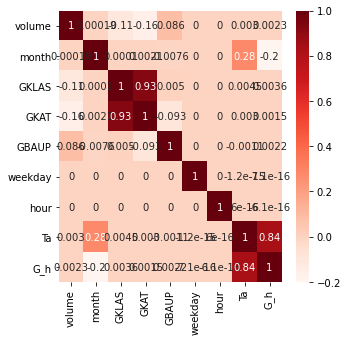

In [94]:
# Correlations --> need to normalize first 
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled = X_scaled.drop(["egid", "surface"], axis=1)

plt.figure(figsize = (5, 5))
cor = X_scaled.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)

## Hyperparameter tuning and model selection
Random search with 4-fold cross validation

### Random Grid Search

In [95]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,5,10,15]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}### Random Hyperparameter Grid

In [96]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 4 fold cross validation, 
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_tr, y_tr)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.7min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Best hyperparameters and model

In [97]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 15,
 'min_samples_leaf': 15,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': True}

In [98]:
best = rf_random.best_estimator_
y_pred = best.predict(x_te)

In [99]:
energy_prediction.iloc[0:len(x_te),2] = y_pred.astype(int)
energy_prediction['difference_of_energy'] = np.abs(energy_prediction['predicted_energy'].sub(energy_prediction['Satom_energy'], axis = 0))
energy_prediction['surface_energy']= energy_prediction["difference_of_energy"]/energy_prediction["surface"]
energy_prediction['normalised_prediction']= energy_prediction["predicted_energy"]/energy_prediction["surface"]

In [100]:
energy_prediction['tag'] = pd.DataFrame(np.repeat('test', len(x_te)))
energy_prediction = energy_prediction.fillna('train')
energy_prediction

,EGID,Satom_energy,predicted_energy,surface,difference_of_energy,surface_energy,normalised_prediction,tag
0,191279011.0,707,117645.0,19.240631,116938.0,6077.659303,6114.404460,test
1,190620412.0,41640,118197.0,191.920156,76557.0,398.900259,615.865485,test
2,9014587.0,24860,107981.0,88.016490,83121.0,944.379854,1226.826928,test
3,925423.0,2304,177158.0,104.969940,174854.0,1665.753072,1687.702213,test
4,9038070.0,0,122592.0,250.052772,122592.0,490.264511,490.264511,test
...,...,...,...,...,...,...,...,...
1951,9038070.0,20075,20075.0,250.052772,0.0,0.000000,80.283053,train
1952,190620412.0,134300,134300.0,191.920156,0.0,0.000000,699.770169,train
1953,190176833.0,9166,9166.0,263.985158,0.0,0.000000,34.721649,train
1954,191293230.0,68057,68057.0,49.047188,0.0,0.000000,1387.582097,train


### Model Evaluation on test data

volume     0.379338
GBAUP      0.164996
G_h        0.104520
month      0.093066
Ta         0.089351
GKAT       0.075178
weekday    0.065187
hour       0.018655
GKLAS      0.009709
dtype: float64


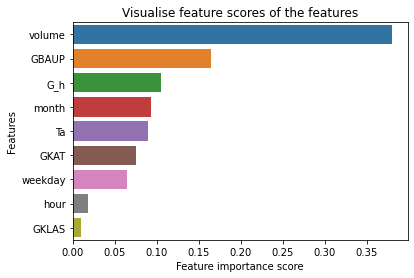

In [101]:
# Feature importance

feature_scores = pd.Series(best.feature_importances_, index=x_tr.columns).sort_values(ascending=False)
print(feature_scores)

# Creating seaborn bar plot
#f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualise feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [102]:
#calculating mean surface in order to normalise the results later on

mean_surface_calculation = energy_prediction[energy_prediction['tag']=='test']
mean_surface_calculation = mean_surface_calculation.drop_duplicates(['EGID'])

mean_surface = mean_surface_calculation['surface'].mean()
mean_surface

131.7817004641444

In [103]:
# Metrics

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_te, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_te, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_te, y_pred)))

print('Mean Absolute Error normalised:', metrics.mean_absolute_error(y_te, y_pred)/mean_surface)
print('Mean Squared Error normalised:', metrics.mean_squared_error(y_te, y_pred)/mean_surface)
print('Root Mean Squared Error normalised:', np.sqrt(metrics.mean_squared_error(y_te, y_pred)/mean_surface))
    
energy_prediction["Difference normalised by surface"] = energy_prediction["difference_of_energy"]/energy_prediction["surface"]
energy_prediction['normalised_prediction'] = energy_prediction['predicted_energy']/energy_prediction["surface"]
energy_prediction['Satom_energy normalised by surface'] = energy_prediction['Satom_energy']/energy_prediction["surface"]

energy_prediction_15 = energy_prediction
energy_prediction_15

Mean Absolute Error: 288925.4598475143
Mean Squared Error: 1718327454664.4727
Root Mean Squared Error: 1310849.8978389832
Mean Absolute Error normalised: 2192.4550892111615
Mean Squared Error normalised: 13039196251.166914
Root Mean Squared Error normalised: 114189.3000730231


,EGID,Satom_energy,predicted_energy,surface,difference_of_energy,surface_energy,normalised_prediction,tag,Difference normalised by surface,Satom_energy normalised by surface
0,191279011.0,707,117645.0,19.240631,116938.0,6077.659303,6114.404460,test,6077.659303,36.745157
1,190620412.0,41640,118197.0,191.920156,76557.0,398.900259,615.865485,test,398.900259,216.965226
2,9014587.0,24860,107981.0,88.016490,83121.0,944.379854,1226.826928,test,944.379854,282.447073
3,925423.0,2304,177158.0,104.969940,174854.0,1665.753072,1687.702213,test,1665.753072,21.949141
4,9038070.0,0,122592.0,250.052772,122592.0,490.264511,490.264511,test,490.264511,0.000000
...,...,...,...,...,...,...,...,...,...,...
1951,9038070.0,20075,20075.0,250.052772,0.0,0.000000,80.283053,train,0.000000,80.283053
1952,190620412.0,134300,134300.0,191.920156,0.0,0.000000,699.770169,train,0.000000,699.770169
1953,190176833.0,9166,9166.0,263.985158,0.0,0.000000,34.721649,train,0.000000,34.721649
1954,191293230.0,68057,68057.0,49.047188,0.0,0.000000,1387.582097,train,0.000000,1387.582097


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-10.0, 500000.0)

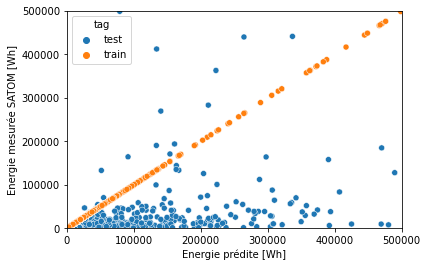

In [104]:
sns.scatterplot(energy_prediction['predicted_energy'], energy_prediction['Satom_energy'], hue=energy_prediction['tag'])
plt.xlabel("Energie prédite [Wh]")
plt.ylabel("Energie mesurée SATOM [Wh]")

## Analysis by GBAUP

In [105]:
energy_prediction_15_GBAUP_temp = energy_prediction_15.drop(["surface", "Satom_energy", "predicted_energy", "difference_of_energy"], axis = 1)
energy_prediction_15_GBAUP = pd.merge(energy_prediction_15_GBAUP_temp, data_model_15, left_on="EGID", right_on="egid", how="inner")
energy_prediction_15_GBAUP = energy_prediction_15_GBAUP[energy_prediction_15_GBAUP['tag']=='test']

energy_prediction_15_GBAUP_difference = energy_prediction_15_GBAUP.drop([ "GKLAS", "volume", "normalised_prediction","GKAT"], axis =1)
energy_prediction_15_GBAUP_difference = energy_prediction_15_GBAUP_difference.groupby(["GBAUP"], as_index=False)["Difference normalised by surface"].mean()


energy_prediction_15_GBAUP_normalised = energy_prediction_15_GBAUP.drop([ "EGID", "GKLAS", "volume","Difference normalised by surface","GKAT"], axis =1)
energy_prediction_15_GBAUP_normalised = energy_prediction_15_GBAUP_normalised.groupby(["GBAUP"], as_index=False)["normalised_prediction"].mean()


energy_prediction_15_GBAUP_satom = energy_prediction_15_GBAUP.drop([ "EGID", "GKLAS", "volume","Difference normalised by surface","GKAT","normalised_prediction"], axis =1)
energy_prediction_15_GBAUP_satom = energy_prediction_15_GBAUP_satom.groupby(["GBAUP"], as_index=False)["Satom_energy normalised by surface"].mean()

energy_prediction_15_GBAUP_satom

,GBAUP,Satom_energy normalised by surface
0,8011.0,325.179555
1,8012.0,12613.921543
2,8013.0,446.346438
3,8014.0,8870.413724
4,8015.0,2912.683303
5,8016.0,2189.688671
6,8017.0,3994.875324
7,8018.0,425.555079
8,8019.0,280.196014
9,8021.0,64.653256


Text(0.5, 0, 'GBAUP')

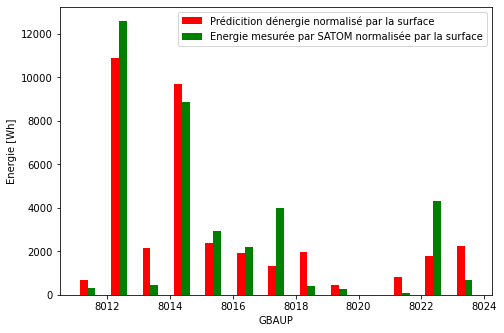

In [111]:
GBAUP_valeurs_reference = [200000, 200000, 210000, 220000, 165000, 125000, 125000, 100000, 100000, 50000, 50000, 50000]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#ax.bar(energy_prediction_15_GBAUP_normalised['GBAUP'] + 0.00, GBAUP_valeurs_reference, color = 'b', width = 0.25)
ax.bar(energy_prediction_15_GBAUP_normalised['GBAUP'] + 0.25, energy_prediction_15_GBAUP_normalised['normalised_prediction'], color = 'r', width = 0.25)
ax.bar(energy_prediction_15_GBAUP_satom['GBAUP'] + 0.50, energy_prediction_15_GBAUP_satom['Satom_energy normalised by surface'], color = 'g', width = 0.25)
ax.legend(labels=['Prédicition d''énergie normalisé par la surface', 'Energie mesurée par SATOM normalisée par la surface'])
ax.set_ylabel('Energie [Wh]')
ax.set_xlabel('GBAUP')
#'Consomation d énergie par surface de référence', 

In [69]:
energy_prediction_15_GBAUP_satom['reference'] = GBAUP_valeurs_reference
energy_prediction_15_GBAUP_satom['percentage difference'] = np.abs(energy_prediction_15_GBAUP_satom['Satom_energy normalised by surface'].sub(energy_prediction_15_GBAUP_normalised['normalised_prediction'])/energy_prediction_15_GBAUP_satom['Satom_energy normalised by surface']*100)
                                                                       
energy_prediction_15_GBAUP_satom['percentage difference'] 

0      134.531358
1        2.188043
2       64.957401
3       60.853155
4      418.899114
5       50.402554
6        2.605661
7       22.220080
8      248.738749
9     2158.315629
10     165.589372
11     529.076526
Name: percentage difference, dtype: float64

## Analysis on GKAT

In [ ]:

data_model_15_temp = data_model_15.drop(['month', 'weekday', 'hour','volume', 'energy', 'season', 'GKLAS', 'GBAUP', 'G_h', 'Ta', 'surface'], axis = 1)
data_model_15_temp = data_model_15_temp.drop_duplicates(subset = ['egid'])
energy_prediction_15_GKAT = pd.merge(energy_prediction_15_GBAUP_temp,  data_model_15_temp, left_on="EGID", right_on="egid", how="inner")
count_GKAT_train = energy_prediction_15_GKAT[energy_prediction_15_GKAT["tag"]=="train"]
number_1030 = count_GKAT_train[count_GKAT_train["GKAT"]==1030].count()
number_1020 = count_GKAT_train[count_GKAT_train["GKAT"]==1020].count()
number_1040 = count_GKAT_train[count_GKAT_train["GKAT"]==1040].count()
number_1060 = count_GKAT_train[count_GKAT_train["GKAT"]==1060].count()

energy_prediction_15_GKAT_temp = energy_prediction_15_GKAT[energy_prediction_15_GKAT["tag"]=="test"]

energy_prediction_15_GKAT_normalised = energy_prediction_15_GKAT_temp.groupby(["GKAT"], as_index=False)["normalised_prediction"].mean()
energy_prediction_15_GKAT_normalised

energy_prediction_15_GKAT_satom = energy_prediction_15_GKAT.groupby(["GKAT"], as_index=False)["Satom_energy normalised by surface"].mean()
energy_prediction_15_GKAT_satom


In [ ]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0,0,1,1])
ax.bar([-0.125,0.875,1.875,2.875 ], energy_prediction_15_GKAT_normalised['normalised_prediction'], color = 'teal', width = 0.25)
ax.bar([0.125,1.125,2.125,3.125 ], energy_prediction_15_GKAT_satom['Satom_energy normalised by surface'], color = 'gold', width = 0.25)
ax.legend(labels=['Prédicition d''énergie normalisée par la surface','Energie mesurée par SATOM normalisée par la surface'])
ax.set_ylabel('Energie [Wh]')
ax.set_xlabel('GKAT')
label = ['1020', '1030', '1040', '1060']
plt.xticks(np.arange(4),label)
ax.set_ylim([0,4500])


# ------------
# Model 18: monthly, weekday, hour, Volume, GKLAS, GBAUP, Ta, global rad --> hourly meteo data

In [16]:
meteo_path = 'Aigle_MeteoSchweiz_2019_v2.cli'
# Take the climate file and remove the header
# keep only columns woth data
meteo_df = pd.read_csv(meteo_path, delimiter=' ')
meteo_df = meteo_df.drop(["FF", "DD", "RH", "N"], axis=1)

In [17]:
data_model_18 = input_output_df[["volume", "egid", "month", "hour", "day_nbr", "weekday","energy", "GKLAS", "GKAT", "GBAUP", "surface"]]

In [18]:
# Add column of season: 

#1 (winter DJF = 12,1,2)
idx_win1 = data_model_18[data_model_18["month"] == 12].index
idx_win2 = data_model_18[data_model_18["month"] == 1].index
idx_win3 = data_model_18[data_model_18["month"] == 2].index

data_model_18.loc[idx_win1, "season"] = 1
data_model_18.loc[idx_win2, "season"] = 1
data_model_18.loc[idx_win3, "season"] = 1

#2 (spring MAM = 3,4,5)
idx_spr1 = data_model_18[data_model_18["month"] == 3].index
idx_spr2 = data_model_18[data_model_18["month"] == 4].index
idx_spr3 = data_model_18[data_model_18["month"] == 5].index

data_model_18.loc[idx_spr1, "season"] = 2
data_model_18.loc[idx_spr2, "season"] = 2
data_model_18.loc[idx_spr3, "season"] = 2

#3 (summer JJA = 6,7,8)
idx_sum1 = data_model_18[data_model_18["month"] == 6].index
idx_sum2 = data_model_18[data_model_18["month"] == 7].index
idx_sum3 = data_model_18[data_model_18["month"] == 8].index

data_model_18.loc[idx_sum1, "season"] = 1
data_model_18.loc[idx_sum2, "season"] = 1
data_model_18.loc[idx_sum3, "season"] = 1


#4 (autumn SON = 9,10,11)
idx_aut1 = data_model_18[data_model_18["month"] == 9].index
idx_aut2 = data_model_18[data_model_18["month"] == 10].index
idx_aut3 = data_model_18[data_model_18["month"] == 11].index

data_model_18.loc[idx_aut1, "season"] = 1
data_model_18.loc[idx_aut2, "season"] = 1
data_model_18.loc[idx_aut3, "season"] = 1

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
# Tri hour 



#1 (hour = 0,1,2)
idx_hr0 = data_model_18[data_model_18["hour"] == 0].index
idx_hr1 = data_model_18[data_model_18["hour"] == 1].index
idx_hr2 = data_model_18[data_model_18["hour"] == 2].index

data_model_18.loc[idx_hr0, "hour"] = 1
data_model_18.loc[idx_hr1, "hour"] = 1
data_model_18.loc[idx_hr2, "hour"] = 1

#2 (hour = 3,4,5)
idx_hr3 = data_model_18[data_model_18["hour"] == 3].index
idx_hr4 = data_model_18[data_model_18["hour"] == 4].index
idx_hr5 = data_model_18[data_model_18["hour"] == 5].index


data_model_18.loc[idx_hr3, "hour"] = 2
data_model_18.loc[idx_hr4, "hour"] = 2
data_model_18.loc[idx_hr5, "hour"] = 2

#3 (hour 6,7,8)
idx_hr6 = data_model_18[data_model_18["hour"] == 6].index
idx_hr7 = data_model_18[data_model_18["hour"] == 7].index
idx_hr8 = data_model_18[data_model_18["hour"] == 8].index

data_model_18.loc[idx_hr6, "hour"] = 3
data_model_18.loc[idx_hr7, "hour"] = 3
data_model_18.loc[idx_hr8, "hour"] = 3


#4 (hour 9,10,11)
idx_hr9 = data_model_18[data_model_18["hour"] == 9].index
idx_hr10 = data_model_18[data_model_18["hour"] == 10].index
idx_hr11 = data_model_18[data_model_18["hour"] == 11].index

data_model_18.loc[idx_hr9, "hour"] = 4
data_model_18.loc[idx_hr10, "hour"] = 4
data_model_18.loc[idx_hr11, "hour"] = 4


#5 (hour 12,13,14)
idx_hr12 = data_model_18[data_model_18["hour"] == 12].index
idx_hr13 = data_model_18[data_model_18["hour"] == 13].index
idx_hr14 = data_model_18[data_model_18["hour"] == 14].index

data_model_18.loc[idx_hr12, "hour"] = 5
data_model_18.loc[idx_hr13, "hour"] = 5
data_model_18.loc[idx_hr14, "hour"] = 5

#6 (hour 15,16,17)
idx_hr15 = data_model_18[data_model_18["hour"] == 15].index
idx_hr16 = data_model_18[data_model_18["hour"] == 16].index
idx_hr17 = data_model_18[data_model_18["hour"] == 17].index

data_model_18.loc[idx_hr15, "hour"] = 6
data_model_18.loc[idx_hr16, "hour"] = 6
data_model_18.loc[idx_hr17, "hour"] = 6


#7 (hour 18,19,20)
idx_hr18 = data_model_18[data_model_18["hour"] == 18].index
idx_hr19 = data_model_18[data_model_18["hour"] == 19].index
idx_hr20 = data_model_18[data_model_18["hour"] == 20].index

data_model_18.loc[idx_hr18, "hour"] = 7
data_model_18.loc[idx_hr19, "hour"] = 7
data_model_18.loc[idx_hr20, "hour"] = 7

#8 (hour 21,22,23)
idx_hr21 = data_model_18[data_model_18["hour"] == 21].index
idx_hr22 = data_model_18[data_model_18["hour"] == 22].index
idx_hr23 = data_model_18[data_model_18["hour"] == 23].index

data_model_18.loc[idx_hr21, "hour"] = 8
data_model_18.loc[idx_hr22, "hour"] = 8
data_model_18.loc[idx_hr23, "hour"] = 8




In [20]:
# Group energy in the same tri-hour --> sum

# Save some egid data for later
stats_value = data_model_18.drop_duplicates(subset=["egid"], keep='first')
stats_value = stats_value[["egid", "GKLAS", "GKAT", "GBAUP"]]

# Sum energies in same tri-hour
tri_hour_values = data_model_18.groupby(["egid", "month", "day_nbr", "weekday", "hour"]).sum()
tri_hour_values = tri_hour_values.reset_index()
tri_hour_values = tri_hour_values.drop(["GKAT", "GKLAS", "GBAUP"], axis=1)

# Merge back the data 
data_model_18 = pd.merge(tri_hour_values, stats_value, left_on="egid", right_on="egid", how="left")

In [21]:
# TRI HOURLY METEO --> hours start at 1

#1 (hour = 1,2,3)
idx_hr0 = meteo_df[meteo_df["h"] == 1].index
idx_hr1 = meteo_df[meteo_df["h"]  == 2].index
idx_hr2 = meteo_df[meteo_df["h"] == 3].index

meteo_df.loc[idx_hr0, "h"] = 1
meteo_df.loc[idx_hr1, "h"] = 1
meteo_df.loc[idx_hr2, "h"] = 1

#2 (hour = 3,4,5)
idx_hr4 = meteo_df[meteo_df["h"]  == 5].index
idx_hr5 = meteo_df[meteo_df["h"]  == 6].index
idx_hr3 = meteo_df[meteo_df["h"]  == 4].index

meteo_df.loc[idx_hr3, "h"] = 2
meteo_df.loc[idx_hr4, "h"] = 2
meteo_df.loc[idx_hr5, "h"] = 2

#3 (hour 6,7,8)
idx_hr6 = meteo_df[meteo_df["h"]  == 7].index
idx_hr7 = meteo_df[meteo_df["h"]  == 8].index
idx_hr8 = meteo_df[meteo_df["h"]  == 9].index

meteo_df.loc[idx_hr6, "h"] = 3
meteo_df.loc[idx_hr7, "h"] = 3
meteo_df.loc[idx_hr8, "h"] = 3


#4 (hour 9,10,11)
idx_hr9 = meteo_df[meteo_df["h"]  == 10].index
idx_hr10 = meteo_df[meteo_df["h"]  == 11].index
idx_hr11 = meteo_df[meteo_df["h"]  == 12].index


meteo_df.loc[idx_hr9, "h"] = 4
meteo_df.loc[idx_hr10, "h"] = 4
meteo_df.loc[idx_hr11, "h"] = 4


#5 (hour 12,13,14)
idx_hr12 = meteo_df[meteo_df["h"]  == 13].index
idx_hr13 = meteo_df[meteo_df["h"]  == 14].index
idx_hr14 = meteo_df[meteo_df["h"]  == 15].index

meteo_df.loc[idx_hr12, "h"] = 5
meteo_df.loc[idx_hr13, "h"] = 5
meteo_df.loc[idx_hr14, "h"] = 5

#6 (hour 15,16,17)
idx_hr15 = meteo_df[meteo_df["h"]  == 16].index
idx_hr16 = meteo_df[meteo_df["h"]  == 17].index
idx_hr17 = meteo_df[meteo_df["h"] == 18].index

meteo_df.loc[idx_hr15, "h"] = 6
meteo_df.loc[idx_hr16, "h"] = 6
meteo_df.loc[idx_hr17, "h"] = 6


#7 (hour 18,19,20)
idx_hr18 = meteo_df[meteo_df["h"]  == 19].index
idx_hr19 = meteo_df[meteo_df["h"]  == 20].index
idx_hr20 = meteo_df[meteo_df["h"]  == 21].index

meteo_df.loc[idx_hr18, "h"] = 7
meteo_df.loc[idx_hr19, "h"] = 7
meteo_df.loc[idx_hr20, "h"] = 7

#8 (hour 21,22,23)
idx_hr21 = meteo_df[meteo_df["h"]  == 22].index
idx_hr22 = meteo_df[meteo_df["h"]  == 23].index
idx_hr23 = meteo_df[meteo_df["h"]  == 24].index

meteo_df.loc[idx_hr21, "h"] = 8
meteo_df.loc[idx_hr22, "h"] = 8
meteo_df.loc[idx_hr23, "h"] = 8



In [22]:
## Add meteo depending on tri-hour

## group by tri-hour month and average except for precipitation 

tri_meteo_df_noP = meteo_df.drop(["RR"],axis = 1)
tri_meteo_df_noP = tri_meteo_df_noP.groupby(["m", "dm",  "h"]).mean()
tri_meteo_df_noP = tri_meteo_df_noP.reset_index()


tri_meteo_df_P = meteo_df.drop(["G_Dh", "G_h", "Ta", "Ts"],axis = 1)
tri_meteo_df_P = tri_meteo_df_P.groupby(["m", "dm",  "h"]).sum()
tri_meteo_df_P = tri_meteo_df_P.reset_index()
tri_meteo_df_P = tri_meteo_df_P['RR']

tri_meteo_final = pd.merge(tri_meteo_df_noP, tri_meteo_df_P, how ="inner", left_index = True, right_index = True)

data_model_18 = pd.merge(data_model_18, tri_meteo_final, left_on=["month", "day_nbr", "hour"], right_on=["m", "dm", "h"], how="left")
data_model_18 = data_model_18.drop(["G_Dh", "Ts"], axis=1)

In [23]:
data_model_18 = data_model_18.drop(["surface"], axis =1)
data_model_18 = pd.merge(data_model_18, floor_areas_final, left_on ="egid", right_index = True, how = 'left')
data_model_18 = data_model_18.rename(columns={"geometry": "surface"})
data_model_18

,egid,month,day_nbr,weekday,hour,volume,energy,season,GKLAS,GKAT,GBAUP,m,dm,h,G_h,Ta,RR,surface
0,925138.0,1,1,1,1,3843.734640,0.0,2.0,1122.0,1020.0,8019.0,1,1,1,2.000000,0.670000,0.0,160.155610
1,925138.0,1,1,1,2,3843.734640,101.0,2.0,1122.0,1020.0,8019.0,1,1,2,1.943333,0.616667,0.0,160.155610
2,925138.0,1,1,1,3,7687.469280,202.0,4.0,1122.0,1020.0,8019.0,1,1,3,34.166667,0.890000,0.0,160.155610
3,925138.0,1,1,1,4,1921.867320,0.0,1.0,1122.0,1020.0,8019.0,1,1,4,298.890000,3.843333,0.0,160.155610
4,925138.0,1,1,1,5,1921.867320,0.0,1.0,1122.0,1020.0,8019.0,1,1,5,214.720000,6.143333,0.0,160.155610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106220,191621572.0,12,31,1,4,322.299332,0.0,1.0,1110.0,1030.0,8016.0,12,31,4,291.886667,2.306667,0.0,40.287417
106221,191621572.0,12,31,1,5,322.299332,0.0,1.0,1110.0,1030.0,8016.0,12,31,5,229.113333,4.676667,0.0,40.287417
106222,191621572.0,12,31,1,6,644.598664,0.0,2.0,1110.0,1030.0,8016.0,12,31,6,13.833333,1.840000,0.0,40.287417
106223,191621572.0,12,31,1,7,322.299332,0.0,1.0,1110.0,1030.0,8016.0,12,31,7,2.000000,0.553333,0.0,40.287417


## Split in test and train

In [ ]:
X = data_model_18[["egid", "volume", "month", "GKLAS", "GKAT", "GBAUP", "weekday", "hour", "Ta", "G_h", "surface"]]
y = pd.DataFrame(data_model_18["energy"])
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2)

# Preparing the final dataframe containing egid, satom energy and predicted energy values
# preparing the final dataframe containing egid, satom energy and predicted energy values
data_energy_prediction = {"EGID": [], "Satom_energy": [], "predicted_energy": [], "surface":[]}
energy_prediction = pd.DataFrame(data_energy_prediction)
energy_prediction['EGID'] = x_te['egid'] 
energy_prediction['surface'] = x_te['surface']
energy_prediction['Satom_energy'] = y_te.astype(int)
to_append = pd.DataFrame()
to_append['EGID'] = x_tr['egid']
to_append['Satom_energy'] = y_tr.astype(int)
to_append['predicted_energy'] = y_tr.astype(int)
to_append['surface'] = x_tr['surface']
energy_prediction = energy_prediction.append(to_append, ignore_index=True)
x_tr = x_tr.drop(["egid", "surface"], axis = 1)
x_te = x_te.drop(["egid", "surface"], axis = 1)

In [ ]:
energy_prediction

In [ ]:
# Correlations --> need to normalize first 
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled = X_scaled.drop(["egid", "surface"], axis=1)

plt.figure(figsize = (5, 5))
cor = X_scaled.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)

## Hyperparameter tuning and model selection
Random search with 4-fold cross validation

#### Random Grid search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,5,10,15]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}### Random Hyperparameter Grid

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 4 fold cross validation, 
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_tr, y_tr)

### Best hyperparameters and model

In [ ]:
rf_random.best_params_

In [ ]:
best = rf_random.best_estimator_
y_pred = best.predict(x_te)

In [ ]:
energy_prediction.iloc[0:len(x_te),2] = y_pred.astype(int)
energy_prediction['difference_of_energy'] = np.abs(energy_prediction['predicted_energy'].sub(energy_prediction['Satom_energy'], axis = 0))
energy_prediction['surface_energy']= energy_prediction["difference_of_energy"]/energy_prediction["surface"]
energy_prediction['normalised_prediction']= energy_prediction["predicted_energy"]/energy_prediction["surface"]

In [ ]:
energy_prediction['tag'] = pd.DataFrame(np.repeat('test', len(x_te)))
energy_prediction = energy_prediction.fillna('train')
energy_prediction

## Feature importance

In [ ]:
# Feature importance

feature_scores = pd.Series(best.feature_importances_, index=x_tr.columns).sort_values(ascending=False)
print(feature_scores)

# Creating seaborn bar plot
#f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## Normalise by surface

In [ ]:
#calculating mean surface in order to normalise the results later on

mean_surface_calculation = energy_prediction[energy_prediction['tag']=='test']
mean_surface_calculation = mean_surface_calculation.drop_duplicates(['EGID'])

mean_surface = mean_surface_calculation['surface'].mean()
mean_surface

### Model Evaluation on test data

In [ ]:
# Metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_te, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_te, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_te, y_pred)))

print('Mean Absolute Error normalised:', metrics.mean_absolute_error(y_te, y_pred)/mean_surface)
print('Mean Squared Error normalised:', metrics.mean_squared_error(y_te, y_pred)/mean_surface)
print('Root Mean Squared Error normalised:', np.sqrt(metrics.mean_squared_error(y_te, y_pred)/mean_surface))
    
energy_prediction["Difference normalised by surface"] = energy_prediction["difference_of_energy"]/energy_prediction["surface"]
energy_prediction['normalised_prediction'] = energy_prediction['predicted_energy']/energy_prediction["surface"]
energy_prediction['Satom_energy normalised by surface'] = energy_prediction['Satom_energy']/energy_prediction["surface"]

energy_prediction_18 = energy_prediction
energy_prediction_18

In [ ]:
sns.scatterplot(energy_prediction['predicted_energy'], energy_prediction['Satom_energy'], hue=energy_prediction['tag'])
plt.xlabel("Energie prédite [Wh]")
plt.ylabel("Energie mesurée SATOM [Wh]")

## Analysis on GBAUP

In [ ]:
energy_prediction_18_GBAUP_temp = energy_prediction_18.drop(["surface", "Satom_energy", "predicted_energy", "difference_of_energy"], axis = 1)
energy_prediction_18_GBAUP = pd.merge(energy_prediction_18_GBAUP_temp, data_model_18, left_on="EGID", right_on="egid", how="inner")
energy_prediction_18_GBAUP = energy_prediction_18_GBAUP[energy_prediction_13_GBAUP['tag']=='test']

energy_prediction_18_GBAUP_difference = energy_prediction_18_GBAUP.drop([ "GKLAS", "volume", "normalised_prediction","GKAT"], axis =1)
energy_prediction_18_GBAUP_difference = energy_prediction_18_GBAUP_difference.groupby(["GBAUP"], as_index=False)["Difference normalised by surface"].mean()


energy_prediction_18_GBAUP_normalised = energy_prediction_18_GBAUP.drop([ "egid", "GKLAS", "volume","Difference normalised by surface","GKAT"], axis =1)
energy_prediction_18_GBAUP_normalised = energy_prediction_18_GBAUP_normalised.groupby(["GBAUP"], as_index=False)["normalised_prediction"].mean()


energy_prediction_18_GBAUP_normalised

In [ ]:
GBAUP_valeurs_reference = [200000, 200000, 210000, 220000, 165000, 125000, 125000, 100000, 100000, 50000, 50000, 50000, 50000] #to adjust

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(energy_prediction_18_GBAUP_normalised['GBAUP'] + 0.00, GBAUP_valeurs_reference, color = 'b', width = 0.25)
ax.bar(energy_prediction_18_GBAUP_normalised['GBAUP'] + 0.25, energy_prediction_18_GBAUP_normalised['normalised_prediction'], color = 'r', width = 0.25)
ax.legend(labels=['Consommation d''énergie par surface de référence', 'Prédicition d''énergie normalisé par la surface'])
ax.set_ylabel('Energie [Wh]')
ax.set_xlabel('GBAUP')

In [ ]:
energy_prediction_18_GBAUP_normalised['reference'] = GBAUP_valeurs_reference
energy_prediction_18_GBAUP_normalised['percentage difference'] = np.abs(energy_prediction_18_GBAUP_normalised['normalised_prediction'].sub(energy_prediction_18_GBAUP_normalised['reference'])/energy_prediction_18_GBAUP_normalised['reference']*100)
                                                                       
energy_prediction_18_GBAUP_normalised['percentage difference'] 

## Analysis on GKAT

In [ ]:
energy_prediction_18_GKAT_temp = energy_prediction_18_GKAT[energy_prediction_18_GKAT["tag"]=="test"]

energy_prediction_18_GKAT_normalised = energy_prediction_18_GKAT_temp.groupby(["GKAT"], as_index=False)["normalised_prediction"].mean()
energy_prediction_18_GKAT_normalised

energy_prediction_18_GKAT_satom = energy_prediction_18_GKAT.groupby(["GKAT"], as_index=False)["Satom_energy normalised by surface"].mean()
energy_prediction_18_GKAT_satom

In [ ]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0,0,1,1])
ax.bar([-0.125,0.875,1.875,2.875 ], energy_prediction_18_GKAT_normalised['normalised_prediction'], color = 'teal', width = 0.25)
ax.bar([0.125,1.125,2.125,3.125 ], energy_prediction_18_GKAT_satom['Satom_energy normalised by surface'], color = 'gold', width = 0.25)
ax.legend(labels=['Prédicition d''énergie normalisée par la surface','Energie mesurée par SATOM normalisée par la surface'])
ax.set_ylabel('Energie [Wh]')
ax.set_xlabel('GKAT')
label = ['1020', '1030', '1040', '1060']
plt.xticks(np.arange(4),label)
ax.set_ylim([0,80])

## MAPE and confidence intervals

In [6]:
energy_prediction_18 = pd.read_csv('energy_prediction_18')
energy_prediction_18['MAPE'] =  np.abs(energy_prediction_18["difference_of_energy"])/energy_prediction_18["Satom_energy"]


# Calculate MAPE and confidence interval

mape_test = energy_prediction_18[energy_prediction_18['tag']=='test']
mape_test = mape_test[~mape_test.isin([np.nan, np.inf, -np.inf]).any(1)]
mape = mape_test['MAPE'].mean()*100
mape

1836.6027218788468

Text(0.5, 1.0, 'Confidence intervals')

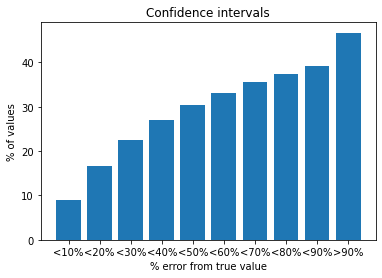

In [7]:
confidence_interval = np.array([len(mape_test[mape_test['MAPE']<0.1])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                             len(mape_test[mape_test['MAPE']<0.2])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              len(mape_test[mape_test['MAPE']<0.3])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              len(mape_test[mape_test['MAPE']<0.4])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              len(mape_test[mape_test['MAPE']<0.5])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              len(mape_test[mape_test['MAPE']<0.6])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              len(mape_test[mape_test['MAPE']<0.7])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              len(mape_test[mape_test['MAPE']<0.8])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              len(mape_test[mape_test['MAPE']<0.9])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              len(mape_test[mape_test['MAPE']>0.9])/len(energy_prediction_18[energy_prediction_18['tag']=='test'])*100,
                              ])

labels = np.array(['<10%', '<20%', '<30%', '<40%', '<50%', '<60%', '<70%', '<80%', '<90%', '>90%'])

plt.bar(labels, confidence_interval)
plt.xlabel("% error from true value")
plt.ylabel("% of values")
plt.title('Confidence intervals')

# ------------
# Model 13: month, weekday vs weekend, daytime,  volume, GKAT, GKLAS, GBAUP

In [112]:
data_model_13 = input_output_df[["volume", "egid", "month", "hour", "weekday", "energy", "GKLAS", "GKAT", "GBAUP", "surface"]]

In [113]:
# Convert weekday to weekend or not

#1 (weekday: 0,1,2,3,4)
data_model_13["weekday"] = data_model_13["weekday"].replace(0, 1)
data_model_13["weekday"] = data_model_13["weekday"].replace(2, 1)
data_model_13["weekday"] = data_model_13["weekday"].replace(3, 1)
data_model_13["weekday"] = data_model_13["weekday"].replace(4, 1)

#2 (weekend: 5,6)
data_model_13["weekday"] = data_model_13["weekday"].replace(5, 2)
data_model_13["weekday"] = data_model_13["weekday"].replace(6, 2)

<ipython-input-113-e160d263f634>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_13["weekday"] = data_model_13["weekday"].replace(0, 1)
<ipython-input-113-e160d263f634>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_13["weekday"] = data_model_13["weekday"].replace(2, 1)
<ipython-input-113-e160d263f634>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [114]:
# Add column of season: 

#1 (winter DJF = 12,1,2)
idx_win1 = data_model_13[data_model_13["month"] == 12].index
idx_win2 = data_model_13[data_model_13["month"] == 1].index
idx_win3 = data_model_13[data_model_13["month"] == 2].index

data_model_13.loc[idx_win1, "season"] = 1
data_model_13.loc[idx_win2, "season"] = 1
data_model_13.loc[idx_win3, "season"] = 1

#2 (spring MAM = 3,4,5)
idx_spr1 = data_model_13[data_model_13["month"] == 3].index
idx_spr2 = data_model_13[data_model_13["month"] == 4].index
idx_spr3 = data_model_13[data_model_13["month"] == 5].index

data_model_13.loc[idx_spr1, "season"] = 2
data_model_13.loc[idx_spr2, "season"] = 2
data_model_13.loc[idx_spr3, "season"] = 2

#3 (summer JJA = 6,7,8)
idx_sum1 = data_model_13[data_model_13["month"] == 6].index
idx_sum2 = data_model_13[data_model_13["month"] == 7].index
idx_sum3 = data_model_13[data_model_13["month"] == 8].index

data_model_13.loc[idx_sum1, "season"] = 1
data_model_13.loc[idx_sum2, "season"] = 1
data_model_13.loc[idx_sum3, "season"] = 1


#4 (autumn SON = 9,10,11)
idx_aut1 = data_model_13[data_model_13["month"] == 9].index
idx_aut2 = data_model_13[data_model_13["month"] == 10].index
idx_aut3 = data_model_13[data_model_13["month"] == 11].index

data_model_13.loc[idx_aut1, "season"] = 1
data_model_13.loc[idx_aut2, "season"] = 1
data_model_13.loc[idx_aut3, "season"] = 1



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [115]:
# Add daytime depending on season

# Winter (1): day from 8am to 5pm --> 1 for day, 2 for night
idx_win = data_model_13[data_model_13["season"] == 1].index
winter_values = data_model_13.loc[idx_win, :]
idx_win_night1 = winter_values[winter_values["hour"]<=8].index
idx_win_night2 = winter_values[winter_values["hour"]>=18].index

data_model_13.loc[idx_win_night1, "hour"] = 2
data_model_13.loc[idx_win_night2, "hour"] = 2

# Spring (2): day from 7am to 7pm
idx_spr = data_model_13[data_model_13["season"] == 2].index
spring_values = data_model_13.loc[idx_spr, :]
idx_spr_night1 = spring_values[spring_values["hour"]<=7].index
idx_spr_night2 = spring_values[spring_values["hour"]>=20].index

data_model_13.loc[idx_spr_night1, "hour"] = 2
data_model_13.loc[idx_spr_night2, "hour"] = 2

# Summer (3): day from 6am to 9pm
idx_sum = data_model_13[data_model_13["season"] ==3].index
summer_values = data_model_13.loc[idx_sum ,:]
idx_sum_night1 = summer_values[summer_values["hour"]<=6].index
idx_sum_night2 = summer_values[summer_values["hour"]>=22].index

data_model_13.loc[idx_sum_night1, "hour"] = 2
data_model_13.loc[idx_sum_night2, "hour"] = 2

# Autumn (4): day from 7am to 7pm
idx_aut = data_model_13[data_model_13["season"] ==4].index
aut_values = data_model_13.loc[idx_aut, :]
idx_aut_night1 = aut_values[aut_values["hour"]<=7].index
idx_aut_night2 = aut_values[aut_values["hour"]>=20].index

data_model_13.loc[idx_aut_night1, "hour"] = 2
data_model_13.loc[idx_aut_night2, "hour"] = 2

#Set all others to day --> as 1
idx_day = data_model_13[data_model_13["hour"] !=2].index
data_model_13.loc[idx_day, "hour"] = 1

In [116]:
data_model_13 = data_model_13.groupby(["egid", "volume", "month", "weekday", "hour", "GKLAS", "GKAT", "GBAUP"]).sum().reset_index().drop(["season"], axis=1)
data_model_13

,egid,volume,month,weekday,hour,GKLAS,GKAT,GBAUP,energy,surface
0,925138.0,1921.867320,1,1,1,1122.0,1020.0,8019.0,3912.0,21781.162960
1,925138.0,1921.867320,1,1,2,1122.0,1020.0,8019.0,6719.0,37796.723961
2,925138.0,1921.867320,1,2,1,1122.0,1020.0,8019.0,1210.0,7367.158060
3,925138.0,1921.867320,1,2,2,1122.0,1020.0,8019.0,2913.0,14574.160510
4,925138.0,1921.867320,2,1,1,1122.0,1020.0,8019.0,3717.0,20499.918080
...,...,...,...,...,...,...,...,...,...,...
1951,191621572.0,322.299332,11,2,2,1110.0,1030.0,8016.0,11586.0,5519.376061
1952,191621572.0,322.299332,12,1,1,1110.0,1030.0,8016.0,2543.0,4351.040982
1953,191621572.0,322.299332,12,1,2,1110.0,1030.0,8016.0,5253.0,7815.758801
1954,191621572.0,322.299332,12,2,1,1110.0,1030.0,8016.0,1209.0,1893.508576


In [117]:
data_model_13 = data_model_13.drop(["surface"], axis =1)
data_model_13 = pd.merge(data_model_13, floor_areas_final, left_on ="egid", right_index = True, how = 'left')
data_model_13 = data_model_13.rename(columns={"geometry": "surface"})
data_model_13

,egid,volume,month,weekday,hour,GKLAS,GKAT,GBAUP,energy,surface
0,925138.0,1921.867320,1,1,1,1122.0,1020.0,8019.0,3912.0,160.155610
1,925138.0,1921.867320,1,1,2,1122.0,1020.0,8019.0,6719.0,160.155610
2,925138.0,1921.867320,1,2,1,1122.0,1020.0,8019.0,1210.0,160.155610
3,925138.0,1921.867320,1,2,2,1122.0,1020.0,8019.0,2913.0,160.155610
4,925138.0,1921.867320,2,1,1,1122.0,1020.0,8019.0,3717.0,160.155610
...,...,...,...,...,...,...,...,...,...,...
1951,191621572.0,322.299332,11,2,2,1110.0,1030.0,8016.0,11586.0,40.287417
1952,191621572.0,322.299332,12,1,1,1110.0,1030.0,8016.0,2543.0,40.287417
1953,191621572.0,322.299332,12,1,2,1110.0,1030.0,8016.0,5253.0,40.287417
1954,191621572.0,322.299332,12,2,1,1110.0,1030.0,8016.0,1209.0,40.287417


## Split in train and test

In [118]:
X = data_model_13[["egid", "volume", "month", "GKLAS", "GKAT", "GBAUP", "weekday", "hour", "surface"]]
y = pd.DataFrame(data_model_13["energy"])
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2)

# Preparing the final dataframe containing egid, satom energy and predicted energy values
data_energy_prediction = {"EGID": [], "Satom_energy": [], "predicted_energy": [], "surface":[]}
energy_prediction = pd.DataFrame(data_energy_prediction)
energy_prediction['EGID'] = x_te['egid'] 
energy_prediction['surface'] = x_te['surface']
energy_prediction['Satom_energy'] = y_te.astype(int)
to_append = pd.DataFrame()
to_append['EGID'] = x_tr['egid']
to_append['Satom_energy'] = y_tr.astype(int)
to_append['predicted_energy'] = y_tr.astype(int)
to_append['surface'] = x_tr['surface']
energy_prediction = energy_prediction.append(to_append, ignore_index=True)
x_tr = x_tr.drop(["egid", "surface"], axis = 1)
x_te = x_te.drop(["egid", "surface"], axis = 1)

In [119]:
energy_prediction

,EGID,Satom_energy,predicted_energy,surface
0,9014514.0,1110,NaN,69.340221
1,3110589.0,11365,NaN,112.178133
2,191293230.0,8851,NaN,49.047188
3,925140.0,1913,NaN,96.557143
4,925447.0,16070,NaN,41.538330
...,...,...,...,...
1951,925707.0,20610,20610.0,108.146731
1952,925229.0,11569140,11569140.0,154.219087
1953,925447.0,22460,22460.0,41.538330
1954,925423.0,12052,12052.0,104.969940


<AxesSubplot:>

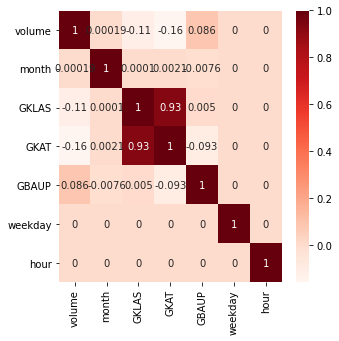

In [120]:
# Correlations --> need to normalize first 
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled = X_scaled.drop(["egid", "surface"], axis=1)

plt.figure(figsize = (5, 5))
cor = X_scaled.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)

## Random Grid Search

In [121]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,5,10,15]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}### Random Hyperparameter Grid

In [122]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 4 fold cross validation, 
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_tr, y_tr)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.1min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

## Best parameters

In [123]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [124]:
best = rf_random.best_estimator_
y_pred = best.predict(x_te)

In [125]:
energy_prediction.iloc[0:len(x_te),2] = y_pred.astype(int)
energy_prediction['difference_of_energy'] = np.abs(energy_prediction['predicted_energy'].sub(energy_prediction['Satom_energy'], axis = 0))
energy_prediction['surface_energy']= energy_prediction["difference_of_energy"]/energy_prediction["surface"]
energy_prediction['normalised_prediction']= energy_prediction["predicted_energy"]/energy_prediction["surface"]

In [126]:
energy_prediction['tag'] = pd.DataFrame(np.repeat('test', len(x_te)))
energy_prediction = energy_prediction.fillna('train')
energy_prediction

,EGID,Satom_energy,predicted_energy,surface,difference_of_energy,surface_energy,normalised_prediction,tag
0,9014514.0,1110,12141.0,69.340221,11031.0,159.085158,175.093183,test
1,3110589.0,11365,11873.0,112.178133,508.0,4.528512,105.840592,test
2,191293230.0,8851,17118.0,49.047188,8267.0,168.551967,349.010834,test
3,925140.0,1913,3601.0,96.557143,1688.0,17.481876,37.293978,test
4,925447.0,16070,74839.0,41.538330,58769.0,1414.813739,1801.685335,test
...,...,...,...,...,...,...,...,...
1951,925707.0,20610,20610.0,108.146731,0.0,0.000000,190.574415,train
1952,925229.0,11569140,11569140.0,154.219087,0.0,0.000000,75017.562758,train
1953,925447.0,22460,22460.0,41.538330,0.0,0.000000,540.705416,train
1954,925423.0,12052,12052.0,104.969940,0.0,0.000000,114.813822,train


## Feature importance

month      0.558447
volume     0.210290
GBAUP      0.092310
weekday    0.059463
hour       0.037900
GKAT       0.034711
GKLAS      0.006880
dtype: float64


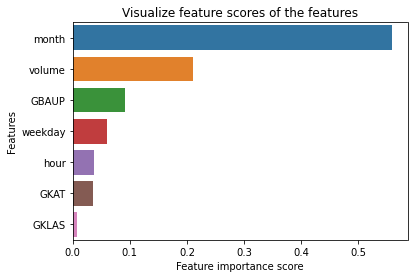

In [127]:
# Feature importance

feature_scores = pd.Series(best.feature_importances_, index=x_tr.columns).sort_values(ascending=False)
print(feature_scores)

# Creating seaborn bar plot
#f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [128]:
mean_surface_calculation = energy_prediction[energy_prediction['tag']=='test']
mean_surface_calculation

mean_surface = mean_surface_calculation['surface'].mean()
mean_surface

118.87392443376763

In [129]:
# Metrics

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_te, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_te, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_te, y_pred)))

print('Mean Absolute Error normalised:', metrics.mean_absolute_error(y_te, y_pred)/mean_surface)
print('Mean Squared Error normalised:', metrics.mean_squared_error(y_te, y_pred)/mean_surface)
print('Root Mean Squared Error normalised:', np.sqrt(metrics.mean_squared_error(y_te, y_pred)/mean_surface))
    
energy_prediction["Difference normalised by surface"] = energy_prediction["difference_of_energy"]/energy_prediction["surface"]
energy_prediction['normalised_prediction'] = energy_prediction['predicted_energy']/energy_prediction["surface"]
energy_prediction['Satom_energy normalised by surface'] = energy_prediction['Satom_energy']/energy_prediction["surface"]

energy_prediction_13 = energy_prediction
energy_prediction_13

Mean Absolute Error: 201343.46142053665
Mean Squared Error: 443861973330.86304
Root Mean Squared Error: 666229.6701069857
Mean Absolute Error normalised: 1693.756325279882
Mean Squared Error normalised: 3733888449.0026855
Root Mean Squared Error normalised: 61105.55170361107


,EGID,Satom_energy,predicted_energy,surface,difference_of_energy,surface_energy,normalised_prediction,tag,Difference normalised by surface,Satom_energy normalised by surface
0,9014514.0,1110,12141.0,69.340221,11031.0,159.085158,175.093183,test,159.085158,16.008025
1,3110589.0,11365,11873.0,112.178133,508.0,4.528512,105.840592,test,4.528512,101.312080
2,191293230.0,8851,17118.0,49.047188,8267.0,168.551967,349.010834,test,168.551967,180.458867
3,925140.0,1913,3601.0,96.557143,1688.0,17.481876,37.293978,test,17.481876,19.812102
4,925447.0,16070,74839.0,41.538330,58769.0,1414.813739,1801.685335,test,1414.813739,386.871595
...,...,...,...,...,...,...,...,...,...,...
1951,925707.0,20610,20610.0,108.146731,0.0,0.000000,190.574415,train,0.000000,190.574415
1952,925229.0,11569140,11569140.0,154.219087,0.0,0.000000,75017.562758,train,0.000000,75017.562758
1953,925447.0,22460,22460.0,41.538330,0.0,0.000000,540.705416,train,0.000000,540.705416
1954,925423.0,12052,12052.0,104.969940,0.0,0.000000,114.813822,train,0.000000,114.813822


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-10.0, 100000.0)

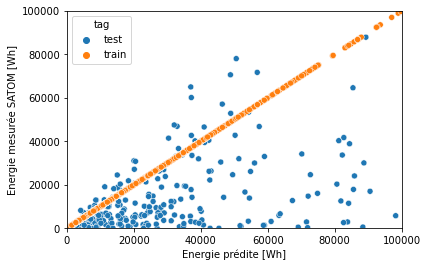

In [130]:
sns.scatterplot(energy_prediction['predicted_energy'], energy_prediction['Satom_energy'], hue=energy_prediction['tag'])
plt.xlabel("Energie prédite [Wh]")
plt.ylabel("Energie mesurée SATOM [Wh]")
plt.xlim(-10,100000)
plt.ylim(-10,100000)

### Analysis on GBAUP

In [131]:
energy_prediction_13_GBAUP_temp = energy_prediction_13.drop(["surface", "Satom_energy", "predicted_energy", "difference_of_energy"], axis = 1)
energy_prediction_13_GBAUP = pd.merge(energy_prediction_13_GBAUP_temp, data_model_13, left_on="EGID", right_on="egid", how="inner")
energy_prediction_13_GBAUP = energy_prediction_13_GBAUP[energy_prediction_13_GBAUP['tag']=='test']


energy_prediction_13_GBAUP_difference = energy_prediction_13_GBAUP.drop([ "GKLAS", "volume", "normalised_prediction","GKAT"], axis =1)
energy_prediction_13_GBAUP_difference = energy_prediction_13_GBAUP_difference.groupby(["GBAUP"], as_index=False)["Difference normalised by surface"].mean()


energy_prediction_13_GBAUP_normalised = energy_prediction_13_GBAUP.drop([ "egid", "GKLAS", "volume","Difference normalised by surface","GKAT"], axis =1)
energy_prediction_13_GBAUP_normalised = energy_prediction_13_GBAUP_normalised.groupby(["GBAUP"], as_index=False)["normalised_prediction"].mean()

energy_prediction_13_GBAUP_satom = energy_prediction_13_GBAUP.drop([ "egid", "GKLAS", "volume","Difference normalised by surface","GKAT","normalised_prediction"], axis =1)
energy_prediction_13_GBAUP_satom = energy_prediction_13_GBAUP_satom.groupby(["GBAUP"], as_index=False)["Satom_energy normalised by surface"].mean()


energy_prediction_13_GBAUP_normalised
energy_prediction_13_GBAUP_satom

,GBAUP,Satom_energy normalised by surface
0,8012.0,364.809229
1,8013.0,1321.702213
2,8014.0,817.207800
3,8015.0,2824.385134
4,8016.0,640.950518
5,8017.0,1507.353196
6,8018.0,5882.450891
7,8019.0,138.248973
8,8021.0,50.743383
9,8022.0,1359.681220


Text(0.5, 0, 'GBAUP')

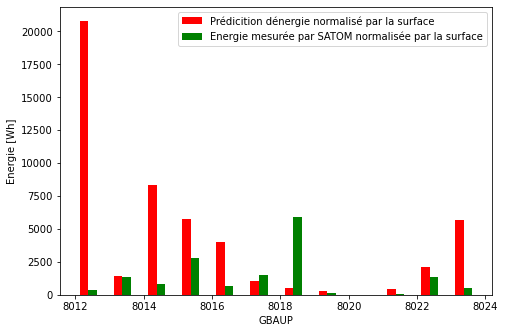

In [135]:
GBAUP_valeurs_reference = [200000, 210000, 220000, 165000, 125000, 125000, 100000, 100000, 50000, 50000, 50000] #to adjust


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#ax.bar(energy_prediction_13_GBAUP_normalised['GBAUP'] + 0.00, GBAUP_valeurs_reference, color = 'b', width = 0.25)
ax.bar(energy_prediction_13_GBAUP_normalised['GBAUP'] + 0.25, energy_prediction_13_GBAUP_normalised['normalised_prediction'], color = 'r', width = 0.25)
ax.bar(energy_prediction_13_GBAUP_satom['GBAUP'] + 0.50, energy_prediction_13_GBAUP_satom['Satom_energy normalised by surface'], color = 'g', width = 0.25)
ax.legend(labels=['Prédicition d''énergie normalisé par la surface', 'Energie mesurée par SATOM normalisée par la surface'])
#'Consommation d energie par surface de référence',
ax.set_ylabel('Energie [Wh]')
ax.set_xlabel('GBAUP')


In [41]:
energy_prediction_13_GBAUP_satom['reference'] = GBAUP_valeurs_reference
energy_prediction_13_GBAUP_satom['percentage difference'] = np.abs(energy_prediction_13_GBAUP_satom['Satom_energy normalised by surface'].sub(energy_prediction_13_GBAUP_normalised['normalised_prediction'])/energy_prediction_13_GBAUP_satom['Satom_energy normalised by surface']*100)
                                                                       
energy_prediction_13_GBAUP_satom['percentage difference'] 

0     114.744230
1     883.275307
2     145.164204
3      14.956104
4      60.718616
5     222.766944
6      51.566625
7      78.384745
8     112.840203
9      59.598007
10     26.380156
11    235.674196
Name: percentage difference, dtype: float64

### Analysis on GKAT

In [ ]:
data_model_13_temp = data_model_13.drop(['month', 'weekday', 'hour','volume', 'energy','GKLAS', 'GBAUP', 'surface'], axis = 1)
data_model_13_temp = data_model_13_temp.drop_duplicates(subset = ['egid'])
energy_prediction_13_GKAT = pd.merge(energy_prediction_13_GBAUP_temp,  data_model_13_temp, left_on="EGID", right_on="egid", how="inner")
count_GKAT_train = energy_prediction_13_GKAT[energy_prediction_13_GKAT["tag"]=="train"]
number_1030 = count_GKAT_train[count_GKAT_train["GKAT"]==1030].count()
number_1020 = count_GKAT_train[count_GKAT_train["GKAT"]==1020].count()
number_1040 = count_GKAT_train[count_GKAT_train["GKAT"]==1040].count()
number_1060 = count_GKAT_train[count_GKAT_train["GKAT"]==1060].count()

energy_prediction_13_GKAT_temp = energy_prediction_13_GKAT[energy_prediction_13_GKAT["tag"]=="test"]

energy_prediction_13_GKAT_normalised = energy_prediction_13_GKAT_temp.groupby(["GKAT"], as_index=False)["normalised_prediction"].mean()
energy_prediction_13_GKAT_normalised

energy_prediction_13_GKAT_satom = energy_prediction_13_GKAT.groupby(["GKAT"], as_index=False)["Satom_energy normalised by surface"].mean()
energy_prediction_13_GKAT_satom

In [ ]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0,0,1,1])
ax.bar([-0.125,0.875,1.875,2.875 ], energy_prediction_13_GKAT_normalised['normalised_prediction'], color = 'teal', width = 0.25)
ax.bar([0.125,1.125,2.125,3.125 ], energy_prediction_13_GKAT_satom['Satom_energy normalised by surface'], color = 'gold', width = 0.25)
ax.legend(labels=['Prédicition d''énergie normalisée par la surface','Energie mesurée par SATOM normalisée par la surface'])
ax.set_ylabel('Energie [Wh]')
ax.set_xlabel('GKAT')
label = ['1020', '1030', '1040', '1060']
plt.xticks(np.arange(4),label)
ax.set_ylim([0,4500])